<a href="https://colab.research.google.com/github/sxergiu/fac-year-3/blob/main/IPR/IPR3_Laboratory_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Recurrent neural networks

First, we add the necessary imports and set a constant seed for the random number generator in PyTorch.

In [ ]:
import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);

Text is one of the most popular examples of sequence data. For example, an article can be simply viewed as a sequence of words, or even a sequence of characters. The common preprocessing steps for text, usually, are:

1. Load text as strings into memory.
1. Split strings into tokens (e.g., words and characters).
1. Build a table of vocabulary to map the split tokens to numerical indices.
1. Convert text into sequences of numerical indices so they can be manipulated by models easily.

To get started we load text from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35). This is a fairly small corpus of just over $30000$ words, but, for the purpose of what we want to illustrate, this is just fine. More realistic document collections contain many billions of words. The `read_time_machine()` function reads the dataset into a list of text lines, where each line is a string. For simplicity, here we ignore punctuation and capitalization.

In [ ]:
def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [ ]:
def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


The following `tokenize()` function takes a list (`lines`) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A *token* is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [ ]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


The string type of the token is inconvenient to be used by models, which take numerical inputs. Now let us build a dictionary, often called *vocabulary* as well, to map string tokens into numerical indices starting from $0$. To do so, we first count the unique tokens in all the documents from the training set, namely a *corpus*, and then assign a numerical index to each unique token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. Any token that does not exist in the corpus or has been removed is mapped into a special unknown token “&lt;unk&gt;”. We optionally add a list of reserved tokens, such as “&lt;pad&gt;” for padding, “&lt;bos&gt;” to represent the beginning of a sequence, and “&lt;eos&gt;” for the end of a sequence.

In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

We construct a vocabulary using the `time machine` dataset as the corpus. Then, we print the first few frequent tokens with their indices.

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


Now, we can convert each text line into a list of numerical indices.

In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


Using the above functions, we package everything into the `load_corpus_time_machine()` function, which returns `corpus`, a list of token indices, and `vocab`, the vocabulary of the time machine corpus.
The modifications we did here are:
(i) we tokenize text into characters, not words, to simplify the later training;
(ii) `corpus` is a single list, not a list of token lists, since each text line in the `time machine` dataset is not necessarily a sentence or a paragraph.

In [ ]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

We can ensure that the subsequences from two adjacent mini-batches during iteration are adjacent on the original sequence. This strategy preserves the order of split subsequences when iterating over mini-batches, hence is called *sequential partitioning*.

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

Let us manually generate a sequence from $0$ to $34$. We assume that the batch size and number of time steps are $2$ and $5$, respectively. This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a mini-batch size of $2$, we only get $3$ mini-batches.

Let us print features `X` and labels `Y` for each mini-batch of subsequences read by sequential partitioning. Note that the subsequences from two adjacent mini-batches during iteration are indeed adjacent in the original sequence.

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


Now, we wrap the above two sampling functions to a class, so that we can use it as a data iterator later.

In [ ]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

Lastly, we define a function `load_data_time_machine()` that returns both the data iterator and the vocabulary, so we can use it similarly as other functions with the `load_data` prefix, such as `load_data_fashion_mnist()` defined in *Laboratory 3*.

In [ ]:
def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In order to implement a language model with RNNs, we use functions provided by the high-level APIs of PyTorch. We begin by reading the `time machine` dataset.

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

High-level APIs provide implementations of recurrent neural networks. We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and $256$ hidden units.

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

We use a tensor to initialize the hidden state, whose shape is
(number of hidden layers, batch size, number of hidden units).

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

With a hidden state and an input, we can compute the output with the updated hidden state. It should be emphasized that the "output" (`Y`) of `rnn_layer` does *not* involve computation of output layers: it refers to the hidden state at *each* time step, and they can be used as the input to the subsequent output layer.

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Recall that each token is represented as a numerical index in `train_iter`. Feeding these indices directly to a neural network might make it hard to learn. We often represent each token as a more expressive feature vector. The easiest representation is called *one-hot encoding*.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (`len(vocab)`) and the token indices range from $0$ to $N-1$. If the index of a token is the integer $i$, then we create a vector of all $0$s with a length of $N$ and set the element at position $i$ to $1$. This vector is the one-hot vector of the original token. The one-hot vectors with indices $0$ and $2$ are shown below.

In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the mini-batch that we sample each time is (batch size, number of time steps). The `F.one_hot()` function transforms such a mini-batch into a three-dimensional tensor, where the last dimension equals to the vocabulary size (`len(vocab)`). We often transpose the input, so that we will obtain an output of shape (number of time steps, batch size, vocabulary size). This will allow us to more conveniently loop through the outermost dimension for updating hidden states of a mini-batch, time step by time step.

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

We define an `RNNModel` class for a complete RNN model. Note that `rnn_layer` only contains the hidden recurrent layers, so we need to create a separate output layer.

In [ ]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

Let us first define the prediction function to generate new characters following
the user-provided `prefix`, which is a string containing several characters.  When looping through these beginning characters in `prefix`, we keep passing the hidden state to the next time step without generating any output. This is called the *warm-up* period, during which the model updates itself (e.g., update the hidden state), but does not make predictions. After the warm-up period, the hidden state is generally better than its initialized value at the beginning. So we generate the predicted characters and emit them.

In [ ]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict()` function. We specify the prefix as `time traveller` and have it generate $10$ additional characters. Given that we have not trained the network yet, i.e., the model has random weights, it will generate nonsensical predictions.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict('time traveller', 10, net, vocab, device)

'time travellervv<unk>vvvvvvv'

Below we define a function to *clip the gradients* of a model that is constructed by the high-level APIs. Also, note that we compute the gradient norm over all the model parameters.

In [ ]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

Before training the model, let us define a function to train the model in one epoch. It differs from how we train the model of *Laboratory 3* in three places:

1. Different types of recurrent layers will result in differences in the initialization of hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge, even when gradients blow up at some point during the training process.
1. We use perplexity to evaluate the model. As discussed in the course, this ensures that sequences of different lengths are comparable.

Specifically, when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch. Since the $i$th subsequence example in the next mini-batch is adjacent to the current $i$th subsequence example, the hidden state at the end of the current mini-batch will be used to initialize the hidden state at the beginning of the next mini-batch. In this way, historical information of the sequence stored in the hidden state might flow over adjacent subsequences within an epoch. However, the computation of the hidden state at any point depends on all the previous mini-batches in the same epoch, which complicates the gradient computation. To reduce computational cost, we detach the gradient before processing any mini-batch, so that the gradient computation of the hidden state is always limited to the time steps in one mini-batch.

Same as the `train_epoch()` function in *Laboratory 3*, `optimizer` is a built-in optimization function in PyTorch.

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

The training function supports an RNN model implemented using high-level APIs.

In [ ]:
def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 50, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 50, net, vocab, device))

    return perplexities

Now we can train the RNN model by calling the `train()` function. Since we only use $10000$ tokens in the dataset, the model needs more epochs to converge better.

In [ ]:
num_epochs, lr = 500, 1
perplexities = train(net, train_iter, vocab, lr, num_epochs, device) #1 min

time traveller the the the the the the the the the the the the t
time traveller and the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the this the thice some that sime time sion so di
time travellere med an ans ano he mant of the thave and have the
time travellerthithe monght rousthe tree the the thatour and the
time travellerickthe thith sion so deand in the reatlist ou the 
time traveller surded this timension of his there that in a dint
time traveller curee and the enot of camd an aile hathist is tha
time traveller pat en sthere wrea touredinst in time tore ard th
time travelleris tha fexthestithe wspectofte sime tiok an thes a
time travellerit to ge there wral thenting thanethe thile creerp
time traveller suthed this soree blate move cong there was avire
time traveller the cince arealdiche time traveller the limather 
time travellerit to ag her aby cand the tome trovelle back the f
time travelleris the prav

Finally, we plot the perplexities obtained during training, using the `plot_perplexity()` function.

In [ ]:
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity')
    plt.title('Training perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()

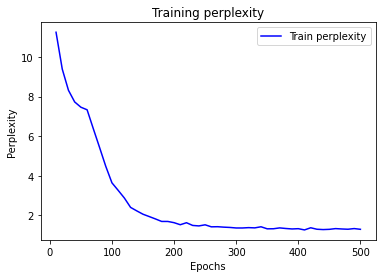

In [ ]:
plot_perplexity(perplexities)

#Gated recurrent units (GRU)

Using PyTorch's high-level APIs, we can directly replace the `nn.RNN` with the `nn.GRU` layer in order to use a gated recurrent unit (GRU). The rest of the code is exactly the same.

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device) #4 min

time traveller te te te te te te te te te te te te te te te te t
time travellere the the the the the the the the the the the the 
time travellere the the the the the the the the the the the the 
time travellere the the the the the the the the the the the the 
time traveller and the the the the the the the the the the the t
time traveller and the the the the the the the the the the the t
time travellerereat and and and and and and and and and and and 
time travellereation the there the there the there the there the
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller and the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the th

We can similarly plot the perplexity during training.

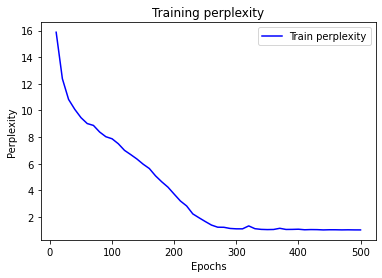

In [ ]:
plot_perplexity(perplexities)

#Long short-term memory (LSTM)

Exactly the same as for the GRU, we replace `nn.RNN` with `nn.LSTM` in order to use a long short-term memory (LSTM). The rest of the code is the same.

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 256, try_gpu()
num_epochs, lr = 500, 1

num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device) #5 min

time traveller                                                  
time traveller  t t t t t t t t t t t t t t t t t t t t t t t t 
time traveller ate the te at ate the te at ate the te at ate the
time traveller the the the the the the the the the the the the t
time travellere the the the the the the the the the the the the 
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time travellerererererererererererererererererererererererererer
time travellerererererererererererererererererererererererererer
time traveller and and the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the thing the thing the time the time the time th
time traveller the time t

We again plot the perplexity during training.

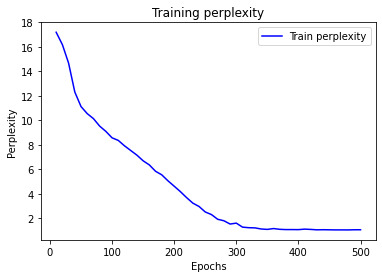

In [ ]:
plot_perplexity(perplexities)

#Deep recurrent neural networks

Fortunately, many of the logistical details required to implement multiple layers of an RNN are readily available in high-level APIs. To keep things simple, we only illustrate the implementation using such built-in functionalities. Let us take an LSTM model as an example. The code is very similar to the one we used previously. In fact, the only difference is that we specify the number of layers explicitly, rather than picking the default of a single layer.

The architectural decisions such as choosing hyperparameters are very similar to those we saw before. We pick the same number of inputs and outputs as we have distinct tokens, i.e., `vocab_size`. The number of hidden units is still $256$. The only difference is that we now select a nontrivial number of hidden layers by specifying the value of `num_layers`.

Since now we instantiate two layers with the LSTM model, this rather more complex architecture slows down training considerably.

In [ ]:
vocab_size, num_hiddens, num_layers, device = len(vocab), 256, 2, try_gpu()
num_epochs, lr = 500, 2

num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device) #11 min

time traveller                                                  
time traveller                                                  
time traveller tate tate tate tate tate tate tate tate tate tate
time traveller ta ae te ae te ae te ae te ae te ae te ae te ae t
time traveller the te te te te te te te te te te te te te te te 
time travellere the the the the the the the the the the the the 
time travellere the the the the the the the the the the the the 
time travellerenthent ant ant ant ant ant ant ant ant ant ant an
time travellerererererererererererererererererererererererererer
time traveller an a the the the the the the the the the the the 
time traveller the the the the the the the the the the the the t
time traveller the there and the time traveller the there and th
time traveller the the the the the the the the the the the the t
time traveller the the than the than the than the than the than 
time traveller thing thisklouns of the thing thingless of there 
time traveller that is th

We can also plot the perplexity during training.

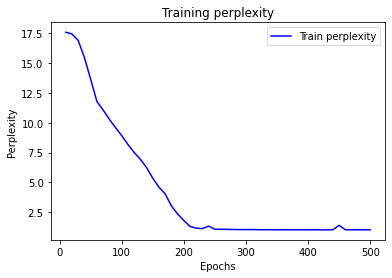

In [ ]:
plot_perplexity(perplexities)

#Sequence to sequence learning

To begin with, we download an English-French dataset that consists of [bilingual sentence pairs from the Tatoeba Project](http://www.manythings.org/anki/). Each line in the dataset is a tab-delimited pair of an English text sequence and the translated French text sequence. Note that each text sequence can be just one sentence or a paragraph of multiple sentences. In this machine translation problem, where English is translated into French, English is the *source language* and French is the *target language*.

In [ ]:
def download_extract(url, folder=None):
    """Download and extract a zip file."""
    fname = download(url)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    else:
        assert False, 'Only zip files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [ ]:
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = download_extract('http://d2l-data.s3-accelerate.amazonaws.com/fra-eng.zip')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



After downloading the dataset, we proceed with several preprocessing steps for the raw text data. For instance, we replace non-breaking space with space, convert uppercase letters to lowercase ones, and insert space between words and punctuation marks.

In [ ]:
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


Different from character-level tokenization we saw earlier, for machine translation we prefer word-level tokenization here (state-of-the-art models may use more advanced tokenization techniques). The following `tokenize_nmt()` function tokenizes the the first `num_examples` text sequence pairs, where each token is either a word or a punctuation mark. This function returns two lists of token lists: `source` and `target`. Specifically, `source[i]` is a list of tokens from the $i$th text sequence in the source language (English here) and `target[i]` is that in the target language (French here).

In [ ]:
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

Let us plot the histogram of the number of tokens per text sequence. In this simple English-French dataset, most of the text sequences have fewer than $20$ tokens.

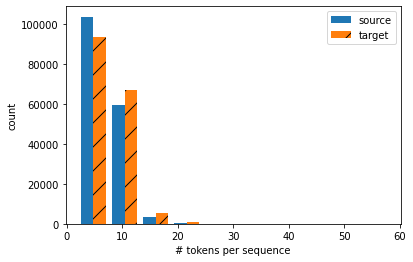

In [ ]:
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    _, _, patches = plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

Since the machine translation dataset consists of pairs of languages, we can build two vocabularies for both the source language and the target language separately. With word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization. To alleviate this, here we treat infrequent tokens that appear less than $2$ times as the same unknown ("&lt;unk&gt;") token. Besides that, we specify additional special tokens such as for padding ("&lt;pad&gt;") sequences to the same length in mini-batches, and for marking the beginning ("&lt;bos&gt;") or end ("&lt;eos&gt;") of sequences. Such special tokens are commonly used in natural language processing tasks.

In [ ]:
src_vocab = Vocab(source, min_freq=2,
                  reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

Recall that, in language modeling, each sequence example, either a segment of one sentence or a span over multiple sentences, has a fixed length. This was specified by the `num_steps` (number of time steps or tokens) argument. In machine translation, each example is a pair of source and target text sequences, where each text sequence may have different lengths.

For computational efficiency, we can still process a mini-batch of text sequences at one time by *truncation* and *padding*. Suppose that every sequence in the same mini-batch should have the same length `num_steps`. If a text sequence has fewer than `num_steps` tokens, we will keep appending the special "&lt;pad&gt;" token to its end, until its length reaches `num_steps`. Otherwise, we will truncate the text sequence by only taking its first `num_steps` tokens and discarding the remaining. In this way, every text sequence will have the same length to be loaded in mini-batches of the same shape.

The following `truncate_pad()` function truncates or pads text sequences, as described before.

In [ ]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

Now, we define a function to transform text sequences into mini-batches for training. We append the special “&lt;eos&gt;” token to the end of every sequence to indicate the end of the sequence. When a model is predicting by generating a sequence token after token, the generation of the “&lt;eos&gt;” token can suggest that the output sequence is complete. Besides, we also record the length of each text sequence excluding the padding tokens. This information will be needed by some models that we will cover later.

In [ ]:
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into mini-batches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    return array, valid_len

Finally, we define the `load_data_nmt()` function to return the data iterator, together with the vocabularies for both the source language and the target language.

In [ ]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

Let us read the first mini-batch from the English-French dataset.

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tensor([[ 7, 35,  4,  3,  1,  1,  1,  1],
        [39, 81,  4,  3,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([4, 4])
Y: tensor([[ 6,  7, 85,  4,  3,  1,  1,  1],
        [ 0,  4,  3,  1,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for Y: tensor([5, 3])


Machine translation is a major problem domain for sequence transduction models, whose input and output are both variable-length sequences. To handle this type of inputs and outputs, we can design an architecture with two major components.
The first component is an *encoder*: it takes a variable-length sequence as the input and transforms it into a state with a fixed shape. The second component is a *decoder*: it maps the encoded state of a fixed shape to a variable-length sequence. This is called an *encoder-decoder* architecture.

Since the encoder-decoder architecture forms the basis of different sequence transduction models, we will first convert this architecture into an interface that will be implemented later.

In the encoder interface, we just specify that the encoder takes variable-length sequences as the input `X`. The implementation will be provided
by any model that inherits this base `Encoder` class.

In [ ]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In the following decoder interface, we add an additional `init_state()` function
to convert the encoder output (`enc_outputs`) into the encoded state. Note that this step may need extra inputs, such as the valid length of the input, which was explained before. To generate a variable-length sequence token by token, every time the decoder may map an input (e.g., the generated token at the previous time step) and the encoded state into an output token at the current time step.

In [ ]:
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In the end, the encoder-decoder architecture contains both an encoder and a decoder, with optionally extra arguments. In the forward propagation, the output of the encoder is used to produce the encoded state, and this state will be further used by the decoder as one of its inputs.

In [ ]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

Now, we will use two RNNs to design the encoder and the decoder of this architecture and apply it to *sequence to sequence* learning for machine translation.

Let us first implement the RNN encoder. Note that we use an *embedding layer* to obtain the feature vector for each token in the input sequence. The weight of an embedding layer is a matrix whose number of rows equals the size of the input vocabulary (`vocab_size`) and number of columns equals the feature vector's dimension (`embed_size`). For any input token index $i$, the embedding layer fetches the $i$th row (starting from $0$) of the weight matrix to return its feature vector. Besides, here we choose a multilayer GRU to implement the encoder.

In [ ]:
class Seq2SeqEncoder(Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # The output `X` shape: (`batch_size`, `num_steps`, `embed_size`)
        X = self.embedding(X)
        # In RNN models, the first axis corresponds to time steps
        X = X.permute(1, 0, 2)
        # When state is not mentioned, it defaults to zeros
        output, state = self.rnn(X)
        # `output` shape: (`num_steps`, `batch_size`, `num_hiddens`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

Let us use a concrete example to illustrate the above encoder implementation. Below we instantiate a two-layer GRU encoder whose number of hidden units is $16$. Given a mini-batch of sequence inputs `X` (batch size: $4$, number of time steps: $7$), the hidden states of the last layer at all the time steps (`output` return by the encoder's recurrent layers) are a tensor of shape (number of time steps, batch size, number of hidden units).

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

Since a GRU is employed here, the shape of the multilayer hidden states at the final time step is (number of hidden layers, batch size, number of hidden units). If an LSTM is used, memory cell information will also be contained in `state`.

In [ ]:
state.shape

torch.Size([2, 4, 16])

When implementing the decoder as follows, we directly use the hidden state at the final time step of the encoder to initialize the hidden state of the decoder. This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units. To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps. To predict the probability distribution of the output token, a fully-connected layer is used to transform the hidden state at the final layer of the RNN decoder.

In [ ]:
class Seq2SeqDecoder(Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # The output `X` shape: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast `context` so it has the same `num_steps` as `X`
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # `output` shape: (`batch_size`, `num_steps`, `vocab_size`)
        # `state` shape: (`num_layers`, `batch_size`, `num_hiddens`)
        return output, state

To illustrate the implemented decoder, below we instantiate it with the same hyperparameters from the aforementioned encoder. As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size), where the last dimension of the tensor stores the predicted token distribution.

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

At each time step, the decoder predicts a probability distribution for the output tokens. Similar to language modeling, we can apply softmax to obtain the distribution and calculate the cross-entropy loss for optimization. Recall that the special padding tokens are appended to the end of sequences, so sequences of varying lengths can be efficiently loaded in mini-batches of the same shape. However, prediction of padding tokens should be excluded from loss calculations.

To this end, we can use the following `sequence_mask()` function to mask irrelevant entries with zero values, so later multiplication of any irrelevant prediction with zero equals to zero. For example, if the valid length of two sequences excluding padding tokens are one and two, respectively, the remaining entries after the first one and the first two entries are cleared to zeros.

In [ ]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

We can also mask all the entries across the last few axes. If we want, we may even specify to replace such entries with a non-zero value.

In [ ]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

Now, we can extend the softmax cross-entropy loss to allow the masking of irrelevant predictions. Initially, masks for all the predicted tokens are set to one. Once the valid length is given, the mask corresponding to any padding token will be cleared to zero. In the end, the loss for all the tokens will be multipled by the mask to filter out irrelevant predictions of padding tokens in the loss.

In [ ]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """The softmax cross-entropy loss with masks."""
    # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`)
    # `label` shape: (`batch_size`, `num_steps`)
    # `valid_len` shape: (`batch_size`,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

For a sanity check, we can create three identical sequences. Then, we can specify that the valid lengths of these sequences are $4$, $2$, and $0$, respectively. As a result, the loss of the first sequence should be twice as large as that of the second sequence, while the third sequence should have a zero loss.

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In the following training loop, we concatenate the special beginning-of-sequence token and the original output sequence, excluding the final token, as the input to the decoder. This is called *teacher forcing*, because the original output sequence (token labels) is fed into the decoder. Alternatively, we could also feed the *predicted* token from the previous time step as the current input to the decoder.

In [ ]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence."""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    train_loss_all = []
    for epoch in range(num_epochs):
        # Sum of training loss, no. of tokens
        total_loss = 0
        total_tokens = 0
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                total_loss += l.sum()
                total_tokens += num_tokens
        if (epoch + 1) % 10 == 0:
            train_loss_all.append(total_loss / total_tokens)
    print(f'loss {total_loss / total_tokens:.3f}, device {str(device)}')

    return train_loss_all

Now, we can create and train an RNN encoder-decoder model for sequence to sequence learning on the machine translation dataset.

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_loss_all = train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device) #1 min

loss 0.019, device cpu


We plot the loss during training using the `plot_loss()` function.

In [ ]:
def plot_loss(train_loss_all):
    epochs = range(10, len(train_loss_all * 10) + 1, 10)
    plt.plot(epochs, train_loss_all, 'b', label='Train loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

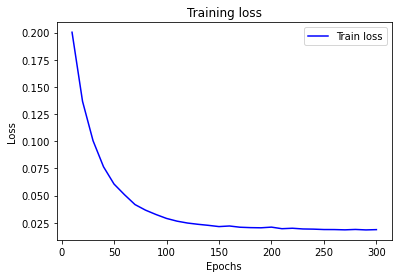

In [ ]:
plot_loss(train_loss_all)

To predict the output sequence token by token, at each decoder time step, the predicted token from the previous time step is fed into the decoder as an input.
Similar to training, at the initial time step, the beginning-of-sequence ("&lt;bos&gt;") token is fed into the decoder. When the end-of-sequence ("&lt;eos&gt;") token is predicted, the prediction of the output sequence is complete.

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

We can evaluate a predicted sequence by comparing it with the label sequence (the ground-truth). BLEU (Bilingual Evaluation Understudy), though originally proposed for evaluating machine translation results, has been extensively used in measuring the quality of output sequences for different applications. In principle, for any $n$-grams in the predicted sequence, BLEU evaluates whether this $n$-grams appears in the label sequence.

We implement the BLEU measure as follows.

In [ ]:
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In the end, we use the trained RNN encoder-decoder to translate a few English sentences into French and compute the BLEU of the results.

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va <unk> ., bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> <unk> ., bleu 0.548
i'm home . => je suis malade ., bleu 0.512
